# Nerdle Solver - Initial Guess Assessment Optimization
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

To find the best initial guess, we map out the game tree.

In [373]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import cProfile
import pstats
from pstats import SortKey

import analysis
import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial Guess Optimization

num_slots 5
Building tree
CPU times: user 165 ms, sys: 2.32 ms, total: 167 ms
Wall time: 170 ms
Best initial guess 1+2=3 #nodes 286 #leaves 217
2 guesses:   8.76%
3 guesses:  43.78%
4 guesses:  24.42%
5 guesses:  23.04%
num_slots 6
Building tree
CPU times: user 104 ms, sys: 1.82 ms, total: 106 ms
Wall time: 108 ms
Best initial guess 3*8=24 #nodes 250 #leaves 206
2 guesses:  15.05%
3 guesses:  83.98%
4 guesses:   0.97%
num_slots 7
Building tree
CPU times: user 2min 21s, sys: 1.22 s, total: 2min 23s
Wall time: 2min 24s
Best initial guess 24-16=8 #nodes 9363 #leaves 7561
2 guesses:   1.44%
3 guesses:  57.23%
4 guesses:  41.33%
num_slots 8
Building tree
CPU times: user 12min 11s, sys: 15.8 s, total: 12min 27s
Wall time: 12min 34s
Best initial guess 58-46=12 #nodes 21593 #leaves 17723
2 guesses:   1.68%
3 guesses:  67.70%
4 guesses:  30.62%


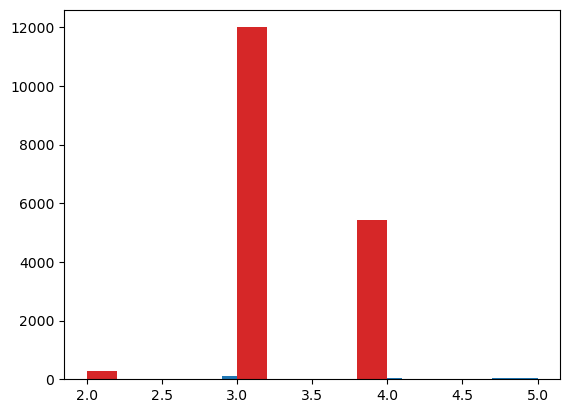

In [555]:
for num_slots in range(5, 9):
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    print("Building tree")
    %time tree = analysis.GameTreeBuilder(solver_data).build()
    tdc = TreeDepthCalculator(tree)
    tree_file = "db/nerdle{}_tree.pkl".format(num_slots) 
    with open(tree_file, 'wb') as f:
        pickle.dump(tree, f)

    # Distribution of #guesses for all answers.
    num_guesses = np.array([depth for node, depth in tdc.depth.items() if not node.children]) + 1
    freq = collections.Counter(num_guesses)
    num_leaves = sum(1 for node in tdc.depth if not node.children)

    print("Best initial guess", tree.key[1], "#nodes", len(tdc.depth), "#leaves", num_leaves)
    for k, v in sorted(freq.items()):
        print("{} guesses: {:6.2f}%".format(k, 100 * v / num_leaves))
    plt.hist(num_guesses);

In [377]:
for num_slots in range(5, 9):
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db
    answers = solver_data.all_keys
    %time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
    b = collections.Counter(d[k]).values()
    print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
        solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))

num_slots 5
CPU times: user 10.6 ms, sys: 125 µs, total: 10.7 ms
Wall time: 10.9 ms
1+2=3 bucket size 42 reduction factor 5.2 # buckets 43
num_slots 6
CPU times: user 9.94 ms, sys: 106 µs, total: 10 ms
Wall time: 10.2 ms
3*8=24 bucket size 10 reduction factor 20.6 # buckets 73
num_slots 7
CPU times: user 7.29 s, sys: 14.6 ms, total: 7.31 s
Wall time: 7.32 s
24-16=8 bucket size 158 reduction factor 47.9 # buckets 543
num_slots 8
CPU times: user 40.6 s, sys: 85.1 ms, total: 40.7 s
Wall time: 40.8 s
58-46=12 bucket size 101 reduction factor 175.5 # buckets 1650


* It seems like odd-size Nerdle is harder than even-size! Larger average #guesses.
* Diversifying symbols of initial guess is a generally good criterion.

In [502]:
num_slots = 7
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db

num_slots 7


In [554]:
cProfile.run('tree = analysis.GameTreeBuilder(solver_data).build()', 'stats')
p = pstats.Stats('stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

Tue Sep 20 09:18:41 2022    stats

         163788460 function calls (163756413 primitive calls) in 204.590 seconds

   Ordered by: cumulative time
   List reduced from 111 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  204.590  204.590 {built-in method builtins.exec}
        1    0.000    0.000  204.590  204.590 <string>:1(<module>)
        1    0.000    0.000  204.263  204.263 /Users/olivne/oren/nerdle-solver/analysis.py:40(build)
   9363/1    0.017    0.000  204.262  204.262 /Users/olivne/oren/nerdle-solver/analysis.py:97(pre_traversal)
     9363    0.048    0.000  204.245    0.022 /Users/olivne/oren/nerdle-solver/analysis.py:51(_process_node)
     1802    3.487    0.002  200.558    0.111 {built-in method builtins.min}
 13619162   92.828    0.000  197.019    0.000 /Users/olivne/oren/nerdle-solver/analysis.py:61(<genexpr>)
 13617361   14.262    0.000   64.075    0.000 /Users/olivne/opt/miniconda3/env

In [460]:
# Basically, scipy.stats.mode() is called only for the root node (the one below for the full answers set).
# Smaller answer sets use counter.most_common().
num_slots = 7
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db
answers = solver_data.all_keys
%time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
b = collections.Counter(d[k]).values()
print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
    solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))
%time min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
%time min((b, k not in answers, k) for k, b in enumerate(scipy.stats.mode(d, axis=1, keepdims=False)[1]))

num_slots 7
CPU times: user 7.32 s, sys: 11 ms, total: 7.33 s
Wall time: 7.33 s
24-16=8 bucket size 158 reduction factor 47.9 # buckets 543


In [549]:
# scipy.stats.mode has a larger overhead than Counter.most_common(), but is faster for large arrays.
for rows in (1000, 10000):
    print(rows)
    for cols in (5, 250, 500):
        print(cols)
        a = np.random.randint(10, size=(rows, cols))
        %time min(collections.Counter(row).most_common(1)[0][1] for row in a);
        %time min(scipy.stats.mode(a, axis=1, keepdims=False)[1]);

1000
5
CPU times: user 5.13 ms, sys: 114 µs, total: 5.24 ms
Wall time: 5.37 ms
CPU times: user 30.9 ms, sys: 4.35 ms, total: 35.2 ms
Wall time: 32 ms
250
CPU times: user 34.9 ms, sys: 175 µs, total: 35 ms
Wall time: 35.2 ms
CPU times: user 28.5 ms, sys: 59 µs, total: 28.6 ms
Wall time: 28.7 ms
500
CPU times: user 54.8 ms, sys: 132 µs, total: 55 ms
Wall time: 55.1 ms
CPU times: user 31.5 ms, sys: 141 µs, total: 31.6 ms
Wall time: 31.7 ms
10000
5
CPU times: user 37.1 ms, sys: 108 µs, total: 37.2 ms
Wall time: 37.3 ms
CPU times: user 203 ms, sys: 1.69 ms, total: 205 ms
Wall time: 204 ms
250
CPU times: user 291 ms, sys: 581 µs, total: 291 ms
Wall time: 292 ms
CPU times: user 267 ms, sys: 930 µs, total: 268 ms
Wall time: 268 ms
500
CPU times: user 545 ms, sys: 839 µs, total: 546 ms
Wall time: 546 ms
CPU times: user 307 ms, sys: 649 µs, total: 307 ms
Wall time: 307 ms
